## Statistical-Text-Analysis 

#### In this notebook, we will attempt to do the following:

1. Find n-grams with n = 1, 2 and 3. 

2. Formulate a hypothesis about them and find a proper way to test the hypothesis.

In [1]:
import os
import nltk
import pandas as pd
import numpy as np
from scipy.stats import poisson
import seaborn as sb
import scipy.stats as stats
import collections
from collections import Counter
import matplotlib as plt
from matplotlib.pyplot import figure
from matplotlib import style
style.use('ggplot')
import re

In [2]:
# Change the current directory to read the data
os.chdir(r"C:\Users\Sultan\Desktop\data\PreprocessedData") 

#### Read the data

In [3]:
#Read csv file into a dataframe
df = pd.read_csv(r'CombinedData.csv', engine='python')
df.head()

,ï»¿word,organization,year
0,fiscal,Guilford County,FY2013
1,year,Guilford County,FY2013
2,adopted,Guilford County,FY2013
3,budget,Guilford County,FY2013
4,brenda,Guilford County,FY2013


In [4]:
# Rename col 0
df.columns = ['word','organization','year']
df.head()

,word,organization,year
0,fiscal,Guilford County,FY2013
1,year,Guilford County,FY2013
2,adopted,Guilford County,FY2013
3,budget,Guilford County,FY2013
4,brenda,Guilford County,FY2013


#### Creating Pandas Series out of the word col

In [5]:
text = df.word
text.head()

0     fiscal
1       year
2    adopted
3     budget
4     brenda
Name: word, dtype: object

#### Extract all elements from the series

In [6]:
# Join the elements and sperate them by a single space
corpus = ' '.join(word for word in text)

In [7]:
corpus[:196] # Let's check the first 196 chars in the series

'fiscal year adopted budget brenda jones county manager sharisse fuller assistant county managerhuman resource director prepared office budget management evaluation michael halford budget director '

In [8]:
# Tokenize the corpus
tokens = nltk.word_tokenize(corpus)

### 1. Uni-grams,  bi-grams and  tri-grams generation process

#### Creating unigrams & computing their frequency

In [9]:
# Create unigrams
ugs_fdist = nltk.FreqDist(tokens)

# Convert nltk freq dist to dictionary
ugs_fdistDic = ugs_fdist.items()

# Build a dataframe out of the dic
ugs_df = pd.DataFrame.from_dict(ugs_fdistDic)

ugs_df.columns = ['unigram','unigram frequency']
ugs_df.head()

,unigram,unigram frequency
0,fiscal,10505
1,year,21434
2,adopted,33916
3,budget,38652
4,brenda,18


#### Bigram

In [10]:
# Create bigrams
bgs = nltk.bigrams(tokens)

# Compute frequency distribution for all the bigrams in the corpus
bgs_fdist = nltk.FreqDist(bgs)

# Convert nltk freq dist to dictonary
bgs_fdistDic = bgs_fdist.items()

# Creating a data frame out of the dictionary 
bgs_df = pd.DataFrame.from_dict(bgs_fdistDic)
bgs_df.columns = ['bigram', 'bigram frequency']
bgs_df.head()

,bigram,bigram frequency
0,"(fiscal, year)",8841
1,"(year, adopted)",4494
2,"(adopted, budget)",7996
3,"(budget, brenda)",1
4,"(brenda, jones)",2


####  Trigram

In [11]:
# Create trigrams
tgs = nltk.trigrams(tokens)

# Compute frequency distribution for all the trigrams in the corpus
tgs_fdist = nltk.FreqDist(tgs)

# Convert nltk freq dist to dictonary
tgs_fdistDic = tgs_fdist.items()

tgs_df = pd.DataFrame.from_dict(tgs_fdistDic)
tgs_df.columns = ['trigram',' trigram frequency']
tgs_df.head()

,trigram,trigram frequency
0,"(fiscal, year, adopted)",4272
1,"(year, adopted, budget)",4361
2,"(adopted, budget, brenda)",1
3,"(budget, brenda, jones)",1
4,"(brenda, jones, county)",2


### Plotting top 10 n-grams

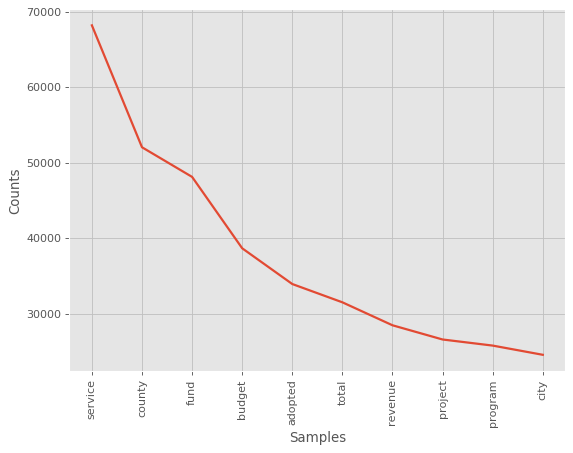

In [12]:
# unigrams
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ugs_fdist.plot(10, cumulative=False)

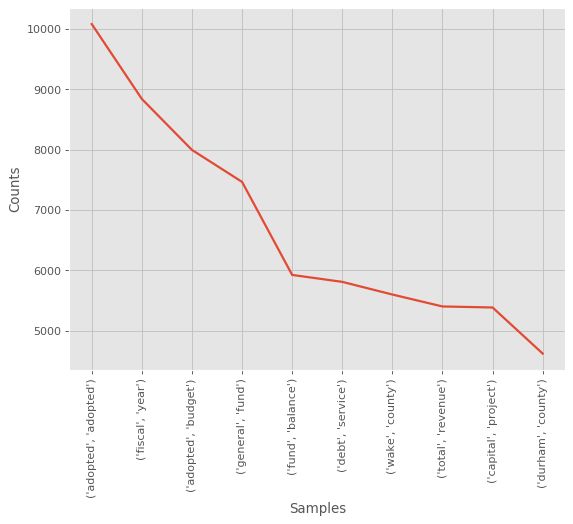

In [13]:
# bigrams
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
bgs_fdist.plot(10, cumulative=False)

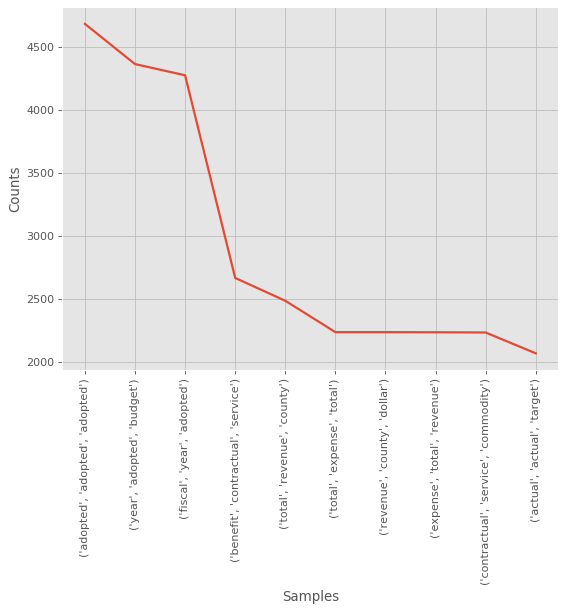

In [14]:
# trigrams
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
tgs_fdist.plot(10, cumulative=False)

In [15]:
# Let's merge all the dataframes
ngrams_df = pd.merge(ugs_df, bgs_df, right_index=True, left_index=True).merge(tgs_df, right_index=True, left_index=True)

ngrams_df.head()

,unigram,unigram frequency,bigram,bigram frequency,trigram,trigram frequency
0,fiscal,10505,"(fiscal, year)",8841,"(fiscal, year, adopted)",4272
1,year,21434,"(year, adopted)",4494,"(year, adopted, budget)",4361
2,adopted,33916,"(adopted, budget)",7996,"(adopted, budget, brenda)",1
3,budget,38652,"(budget, brenda)",1,"(budget, brenda, jones)",1
4,brenda,18,"(brenda, jones)",2,"(brenda, jones, county)",2


### 2.1 Hypothesis and Hypothesis Testing

**Null Hypothesis ($H_0$):         The frequency distribution of the words is independant of the document size.**  
**Alternative Hypothesis ($H_A$):  The frequency distribution of the words is dependant of the document size.**

In [16]:
from collections import Counter 

# Now let's select the data entries from columns 'word' and 'organization' that 
# has the label FY2020 and store it in a different dataframe

FY20_df = df.loc[df['year'] == 'FY2020', ['word', 'organization', 'year']]

# Use loc to slice and extract 2020 data 
gc_df = FY20_df.loc[FY20_df['organization'] == 'Guilford County', ['word', 'organization']]
cc_df = FY20_df.loc[FY20_df['organization'] == 'Charlotte City',  ['word', 'organization']]


In [17]:
# For each text, join the elements and sperate them by a single space
gc_text = gc_df.word 
gc_text = ' '.join(word for word in gc_text)
gc_text = gc_text.split()                   

cc_text = cc_df.word 
cc_text = ' '.join(word for word in cc_text)
cc_text = cc_text.split()                   

# Now let's make a list of lists with each org. having its corresponding text. 
data = [['Guilford County', gc_text], ['Charlotte City', cc_text]]

In [18]:
# One more step, let's create a data frame from the list of lists we have
df_stats = pd.DataFrame(data, columns = ['organization', 'content'])

In [19]:
df_stats

,organization,content
0,Guilford County,"[guilford, county, number, make, count, county..."
1,Charlotte City,"[ensuring, equitable, sustainable, resilient, ..."


In [20]:
# fit the word frequency 
for i in range (0, len(df_stats['content'])):
    counts= list(collections.Counter(df_stats['content'][i]).most_common(1000))
    df_freq = pd.DataFrame(counts, columns=['word', 'frequency'])
    s = np.array(df_freq['frequency'])

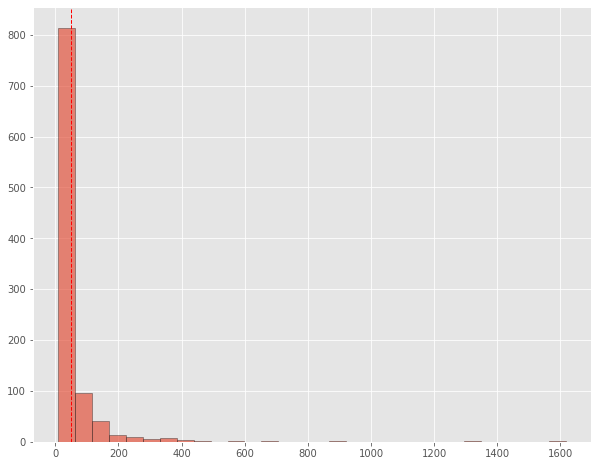

In [21]:
import matplotlib.pyplot as plt

counts1= list(collections.Counter(df_stats['content'][0]).most_common(1000))
df1 = pd.DataFrame(counts1, columns=['word', 'frequency1'])
s1 = np.array(df1['frequency1'])
m1 = df1['frequency1'].mean()

plt.figure(figsize=(10,8))
plt.hist(s1, bins=30, edgecolor='k', alpha=0.65)
plt.axvline(s.mean(), color='r', linestyle='dashed', linewidth=1)

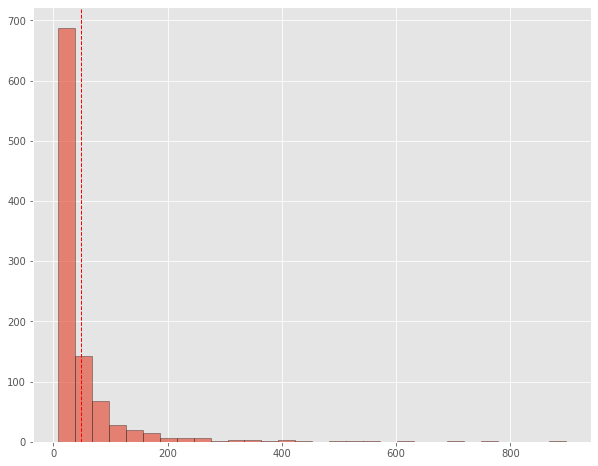

In [22]:
counts2 = list(collections.Counter(df_stats['content'][1]).most_common(1000))
df2 = pd.DataFrame(counts2, columns=['word', 'frequency2'])
s2 = np.array(df2['frequency2'])
m2 = df2['frequency2'].mean()

plt.figure(figsize=(10,8))
plt.hist(s2, bins=30, edgecolor='k', alpha=0.65)
plt.axvline(s.mean(), color='r', linestyle='dashed', linewidth=1)

In [23]:
common_words = pd.merge(df1, df2, on='word', how='inner')
common_words.head()

,word,frequency1,frequency2
0,county,1617,91
1,service,1305,874
2,budget,912,704
3,fund,892,753
4,total,702,614


In [24]:
s1 = common_words['frequency1']
s2= common_words['frequency2']

In [25]:
stats.ttest_ind(a= s1,
                b= s2,
                equal_var=False)

Ttest_indResult(statistic=0.7742338408473467, pvalue=0.43894556137008567)

#### Conclusion: 


Since **P < 0.005**, We reject the $H_0$ and retain $H_1$ that is the frequency distribution of the words is dependant of the document size.

### 2.2 Hypothesis and Hypothesis Testing

In [26]:
len(df.word) # Lengeth of our corpus. We will need it to calculate the chances of occurance

3184264

What we want to know is whether two words co-occur more frequently than chance.

**Null Hypothesis ($H_0$):         There is no assocation between the words beyond chance occurrences.**  
**Alternative Hypothesis ($H_A$):  There is assocation between the words beyond chance occurrences.**

To test our hypothesis we will be using the **t test** that is:

\begin{equation*}
{t} = \frac{\bar x \ - \  u}{\sqrt {\frac {s^2}{N}}}
\end{equation*}

where $\bar x$ is the sample mean, μ is the mean of distribution, $s^2$ is the sample variance, and N is the sample size. 



Consider the bigram sample (fiscal, year) co-occurring 8841 times with its component words fiscal occurring 10505 times and year 21434 times. Now to compute the chances of their co-occurrances we will use the maximum likelihood that is to find:

\begin{equation*}
{P(W_1 \ W_2)} = {P(W_1)} \ {x} \  {P(W_2)}
\end{equation*}


Our corpus consists of '3184264' tokens, so to find to the probability of the occurance of one word is as follows:

\begin{equation*}
{P(W)} = \frac{W \ number \ of \ occurrences}{number \ of \ tokens}
\end{equation*}

So, 

\begin{equation*}
{P(fiscal)} = \frac{10505}{3184264} \approx {\ 0.00330} 
\end{equation*}

And, 

\begin{equation*}
{P(year)} = \frac{21434}{3184264} \approx {\ 0.00673}
\end{equation*}

                  
${H_0}:$

\begin{equation*}
{P(fiscal \ year)} = {P(fiscal)}{\ x \ }{P(year)} = {(0.00330)} \ {x} \  {(0.00673)} \approx {2.2209 x 10 \ ^{- \ 5}}
\end{equation*}


               
The statment made is that the co-occurrences of the words **fiscal** and **year** is indepandent. 

The variance $a^{2} = p(p-1) \approx p$ as p is small. 

The mean for the this specific distribution is 

\begin{equation*}
{u} \approx {2.2209 \ x \  10 \ ^{- \ 5}}
\end{equation*}

The sample mean $\bar x$ = $ \frac {8841}{3184264} = 0.002780 $

#### Now we have got everything we need for t test, let's apply it.

\begin{equation*}
{t} = \frac{\bar x \ - \  u}{\sqrt {\frac {s^2}{N}}}
\end{equation*}

\begin{equation*}
 = \frac{ 0.002780 \ - \  2.2209 \ x \ 10 \ ^{− \ 5}} {\sqrt {\frac {0.002780}{3184264}}} \approx {3.1366024 \ x \  10 \ ^{- \ 4}}
\end{equation*}

Reject or accept $H_0$? 

Reject as t value is less than chance occurrences.

## Work Cited

**[Chris Manning and Hinrich Schütze, Foundations of Statistical Natural Language Processing, MIT Press. Cambridge, MA: May 1999.](https://nlp.stanford.edu/fsnlp/)** 